# Handling advected emissions and satellite data

## Get advected emissions at a given time

In [1]:
import pathlib
from datetime import datetime, timedelta, time
import pickle
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

In [2]:
emissions_path = pathlib.Path("/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/emissions_tracked")

In [3]:
date = datetime(2021, 1, 3)
# due to a disappearance of data, this currently only works for the year of 2021
# I am working on fixing this

the emissions are taken at the time of satellite overpasses and then the satellite data is taken at the emissions' locations

for a given day, we first load the ship locations of the entire day and the day before 

In [4]:
print("working on day:", date.strftime("%Y-%m-%d"))

emissions_df = pd.read_csv(emissions_path/f"{date.year:04d}"/f"{date.month:02d}_{date.day:02d}")
                           
day_before = date - timedelta(days=1)
try:
    emissions_before = pd.read_csv(emissions_path/f"{day_before.year:04d}"/f"{day_before.month:02d}_{day_before.day:02d}")
    
    # we add an arbitrary number to the particle column, which IDs individual ships, to distinguish the day and the day before
    emissions_before.particle=emissions_before.particle+10000 
    
    emissions_df=pd.concat([emissions_before, emissions_df])

except FileNotFoundError: 
    print("location file not found for", date.strftime("%Y-%m-%d"))

emissions_df=emissions_df.set_index(pd.to_datetime(emissions_df['hour']))
emissions_df=emissions_df.drop(columns=['hour']).sort_index()


working on day: 2021-01-03


In [5]:
emissions_df

,y,x,mass,signal,particle,latitude,longitude
hour,,,,,,,
2021-01-02 00:00:00,2.930693,1716.445545,3.654228,0.397985,10000,49.853465,-4.177723
2021-01-02 00:00:00,4.983146,1055.275281,6.440124,0.868331,10001,49.750843,-37.236236
2021-01-02 00:00:00,5.015267,1680.274809,4.739642,0.615068,10002,49.749237,-5.986260
2021-01-02 00:00:00,7.191919,1614.191919,3.581867,0.542707,10004,49.640404,-9.290404
2021-01-02 00:00:00,7.000000,1650.755556,3.256242,0.397985,10005,49.650000,-7.462222
...,...,...,...,...,...,...,...
2021-01-03 23:00:00,1933.604938,284.000000,3.513032,0.607191,2735,-46.680247,-75.800000
2021-01-03 23:00:00,1935.150794,558.317460,5.464717,0.737303,3784,-46.757540,-62.084127
2021-01-03 23:00:00,1947.767857,275.482143,2.428763,0.346966,2134,-47.388393,-76.225893


here are 48h ship trajectories, all overlaid onto each other

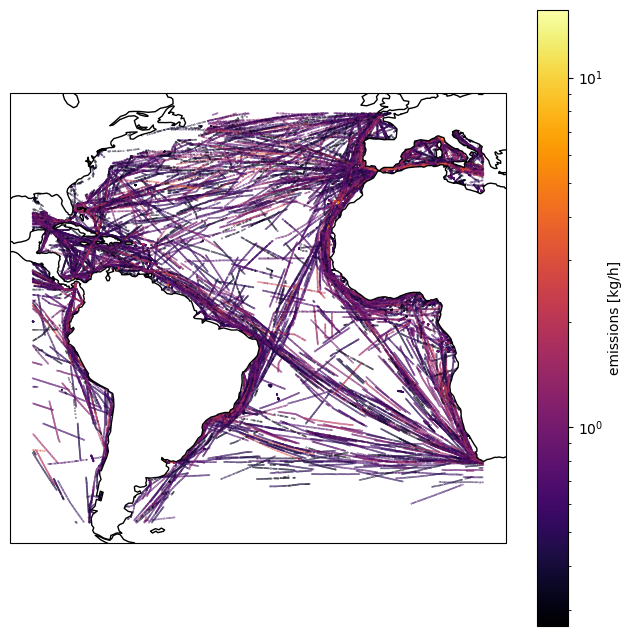

In [6]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(emissions_df.longitude, emissions_df.latitude, c=emissions_df.signal, cmap='inferno',norm=matplotlib.colors.LogNorm(), s=0.05,)
plt.colorbar(label='emissions [kg/h]')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='white'))

this section is for working with modis: we get the time of the overpass in order to know how long we should follow the emissions with the wind


In [7]:
# if year=='2019':
#     infile = open('/home/users/pete_nut/IV_shiptracks/modis_tiles/atlantic_modis_swaths_intersect_{}_{}.pkl'.format(year, month),'rb')
# else: 
#     infile = open('/home/users/pete_nut/IV_shiptracks/modis_tiles/modis_swaths_intersect_{}_{}.pkl'.format(year, month),'rb')
# swath_dict = pickle.load(infile)
# infile.close()

but here we just decide on an arbitrary time for demonstration

In [8]:
overpass_time = time(8, 30)
time_of_overpass = datetime.combine(date.date(), overpass_time)

print(time_of_overpass.strftime("%Y-%m-%d %H:%M"))

2021-01-03 08:30


we cut the data down to the 24h preceding the time of interest (overpass)

In [9]:
emissions_advected = emissions_df.copy().loc[time_of_overpass-timedelta(hours=24):time_of_overpass,:].sort_values('particle')
emissions_advected

,y,x,mass,signal,particle,latitude,longitude
hour,,,,,,,
2021-01-03 01:00:00,6.000000,1609.841727,5.097493,0.586762,0,49.700000,-9.507914
2021-01-03 03:00:00,5.000000,1594.358025,5.186482,0.608291,0,49.750000,-10.282099
2021-01-03 04:00:00,5.000000,1587.238938,4.491908,0.675774,0,49.750000,-10.638053
2021-01-03 02:00:00,5.915966,1603.932773,4.560768,0.613213,0,49.704202,-9.803361
2021-01-03 08:00:00,4.013072,1557.281046,5.149259,0.639450,0,49.799346,-12.135948
...,...,...,...,...,...,...,...
2021-01-02 21:00:00,1767.833333,644.264706,3.151020,0.432493,14129,-38.391667,-57.786765
2021-01-02 23:00:00,1771.904762,635.396825,2.619478,0.374211,14129,-38.595238,-58.230159
2021-01-02 22:00:00,1945.373684,296.400000,6.713599,0.918703,14130,-47.268684,-75.180000


for each of the 24h preceding the overpass, we get the emissions from that time, load the file that contains the advected emissions and finally replace the location of emission with the simulated location at the time of interest

In [10]:
advection_path_eo1 = pathlib.Path("/gws/nopw/j04/eo_shared_data_vol1/satellite/modistracks/hysplit_adv_20m_non_isob")
advection_path_eo2 = pathlib.Path("/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/hysplit_adv_20m_non_isob")

In [11]:
for i, t in enumerate(np.unique(emissions_advected.index)):
    print(i+1, '/', len(np.unique(emissions_advected.index)))

    start_time=emissions_advected.index.where(emissions_advected.index==t).dropna()[0]
    break

1 / 24


In [12]:
for i, t in enumerate(np.unique(emissions_advected.index)):
    print(i+1, '/', len(np.unique(emissions_advected.index)))

    start_time = pd.to_datetime(t).to_pydatetime()

    # Skip this loop if time_of_overpass is less than the emissions start time
    if (time_of_overpass - start_time).total_seconds() < 0: 
        continue
    
    try:
        if start_time.year in (2017, 2018, 2019):
            filloc = advection_path_eo2/f"{start_time.year:04d}_{start_time.month:02d}_{start_time.day:02d}_{start_time.hour:02d}:{start_time.minute:02d}"
        else: 
            filloc = advection_path_eo1/f"{start_time.year:04d}_{start_time.month:02d}_{start_time.day:02d}_{start_time.hour:02d}:{start_time.minute:02d}"
        # this csv file has the locations where emissions from year, month, day, 
        # start_time end up at any given moment within 24h in 5min steps
        trajectories_df = pd.read_csv(filloc)
        
        trajectories_df.loc[:,"jday"] = pd.to_datetime(trajectories_df.jday)
        
        trajectories_df = trajectories_df[trajectories_df.jday==time_of_overpass]
        
        if len(trajectories_df) != len(emissions_advected[emissions_advected.index==t]):
            for i in range(1, len(emissions_advected[emissions_advected.index==t]) + 1):
                if not np.isin(i, np.unique(trajectories_df.particle)):
                    print('missing particle', i)
                    new_row = {'particle':i, 'jday':time_of_overpass, 'lat':np.nan, 'lon':np.nan , 'alt':np.nan, 'timestep':np.nan }
                    #append row to the dataframe
                    trajectories_df = pd.concat([trajectories_df, pd.DataFrame([new_row])], ignore_index=True)
                    trajectories_df = trajectories_df.sort_values('particle') 
                else: None
        else: None
        emissions_advected.loc[emissions_advected.index==t, "latitude"] = trajectories_df.lat.values
        emissions_advected.loc[emissions_advected.index==t, "longitude"] = trajectories_df.lon.values

    except FileNotFoundError:
        emissions_advected.latitude[emissions_advected.index==t] = np.nan
        emissions_advected.longitude[emissions_advected.index==t] = np.nan
        print('no hysplit data for {}'.format(start_time))

1 / 24
missing particle 1623
2 / 24
3 / 24
4 / 24
5 / 24
6 / 24
7 / 24
8 / 24
9 / 24
10 / 24
11 / 24
12 / 24
13 / 24
14 / 24
15 / 24
16 / 24
17 / 24
18 / 24
19 / 24
20 / 24
21 / 24
22 / 24
23 / 24
24 / 24


The latitude and longitude of each row have now been updated with the advected locations

In [15]:
emissions_advected

,y,x,mass,signal,particle,latitude,longitude
hour,,,,,,,
2021-01-03 01:00:00,6.000000,1609.841727,5.097493,0.586762,0,47.366,-11.066
2021-01-03 03:00:00,5.000000,1594.358025,5.186482,0.608291,0,48.148,-11.501
2021-01-03 04:00:00,5.000000,1587.238938,4.491908,0.675774,0,48.444,-11.664
2021-01-03 02:00:00,5.915966,1603.932773,4.560768,0.613213,0,47.749,-11.189
2021-01-03 08:00:00,4.013072,1557.281046,5.149259,0.639450,0,49.654,-12.281
...,...,...,...,...,...,...,...
2021-01-02 21:00:00,1767.833333,644.264706,3.151020,0.432493,14129,-40.512,-58.022
2021-01-02 23:00:00,1771.904762,635.396825,2.619478,0.374211,14129,-40.600,-58.020
2021-01-02 22:00:00,1945.373684,296.400000,6.713599,0.918703,14130,-47.829,-70.016


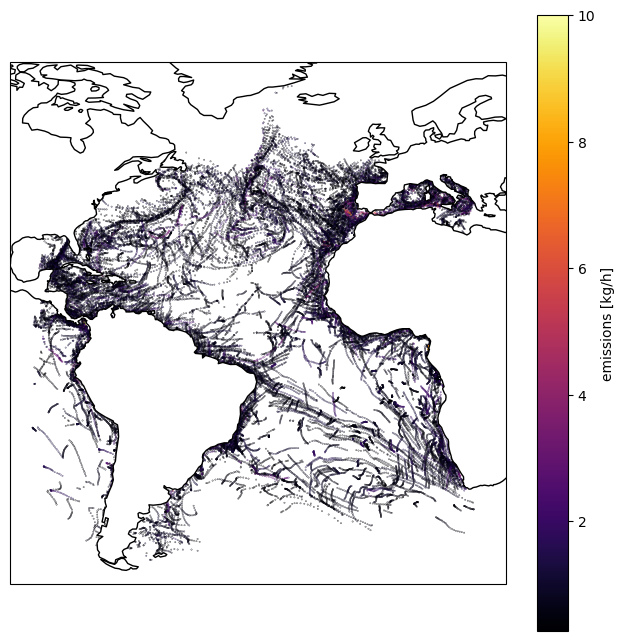

In [14]:
# here, all the trajectories are advected to their locations when the satellite passes
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
plt.figure(figsize=(8,8))
ax = plt.axes(projection=ccrs.PlateCarree())
plt.scatter(emissions_advected.longitude, emissions_advected.latitude, c=emissions_advected.signal, cmap='inferno', s=0.05, vmax=10)
plt.colorbar(label='emissions [kg/h]')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', edgecolor='black', facecolor='white'))

In [13]:
# below here is the code I used to collocate with MODIS. 
# This will be different for a different satellite, I just leave it here as a reference 
        
#     interp_adv=emissions_advected.groupby('particle').resample('5T').interpolate()
#     interp_adv['overpass']=time_of_overpass


#     # clean up
#     interp_adv=interp_adv.drop(columns=['mass', 'y', 'x'])
# #         plt.scatter(interp_adv.longitude, interp_adv.latitude, s=0.1)

#     # subset the emission traj to the observation window in both time and space 
#     mask=[(interp_adv['latitude']<observation_window[0][1])&
#       (interp_adv['longitude']<observation_window[1][1])&
#       (interp_adv['latitude']>observation_window[0][0])&
#       (interp_adv['longitude']>observation_window[1][0])]

#     interp_adv=interp_adv[mask[0]]#.loc[(slice(None),slice(t_first_counted_emis, time_of_overpass)),:]
#     # sometimes, this leaves no tracks to look at
#     if (len(interp_adv.dropna()) == 0) : 
#         print('no overlapping data')
#         continue


# #get modis data
#     # mod_hr=read_data_list(modis_daily,
#     #                    ['Cloud_Top_Temperature'])
#     print('loading modis file') 
#     mod_lr=read_data_list(filename,
#                         ['Cloud_Effective_Radius',
#                         'Cloud_Effective_Radius_Uncertainty', 
#                         'Cloud_Phase_Optical_Properties',
#                         'Cloud_Water_Path',
#                         'Cloud_Optical_Thickness',
#                         # 'cloud_top_pressure_1km'
#                         'cloud_top_temperature_1km'
#                         ], product='MOD06_HACK')
#     # mod_lr_2=read_data_list(filename, ['Cloud_Top_Height'], product='MOD06_HACK')
#     print('done loading modis file',filename)
#     # want liquid clouds with low uncertainty in r_eff estimate
#     sat_mask=(mod_lr[2].data==2) & (mod_lr[1].data<=10)
#     xy=UngriddedDataList([mod_lr[0][sat_mask], mod_lr[3][sat_mask], mod_lr[4][sat_mask], mod_lr[5][sat_mask]])
#     # xy2=UngriddedDataList([mod_lr_2[0]] )

#     modis_coord_box=[[mod_lr.coords('latitude')[0].points.min(), 
#        mod_lr.coords('latitude')[0].points.max()],
#        [mod_lr.coords('longitude')[0].points.min(),           
#        mod_lr.coords('longitude')[0].points.max()]]

#     mask_hysplit_from_modis=[(interp_adv['latitude']<modis_coord_box[0][1])&
#       (interp_adv['longitude']<modis_coord_box[1][1])&
#       (interp_adv['latitude']>modis_coord_box[0][0])&
#       (interp_adv['longitude']>modis_coord_box[1][0])]

#     interp_adv=interp_adv[mask_hysplit_from_modis[0]]
#     # sometimes, this leaves no tracks to look at
#     if (len(interp_adv.dropna()) == 0) : 
#         print('no overlapping data')
#         continue

#     # get shifted trajectories for unpolluted counterfactual
#     offsets=get_offset(interp_adv, np.unique(interp_adv.particle.values), 0.3)

#     shifted_adv=interp_adv.copy()
#     shifted_adv2=interp_adv.copy()
#     shifted=[shifted_adv,interp_adv,shifted_adv2]
#     n_traj = len(shifted)
#     k = n_traj//2

#     for i in np.unique(interp_adv.particle.values):
#         i=int(i)
#         for j, current_traj in enumerate(shifted):
#             current_traj.loc[i].longitude = interp_adv.loc[i].longitude.values + (j-k) * offsets[i][0]
#             current_traj.loc[i].latitude = interp_adv.loc[i].latitude.values + (j-k) * offsets[i][1]

#     for j, current_traj in enumerate(shifted):
#         current_traj.index = current_traj.index.droplevel(0)


#     # wrangle datasets (need to be merged before collocating to save time)
#     concatenated=pd.concat(shifted)

#     # create cis UngriddedData object from DataFrame
#     tracks_ungridded=UngriddedData_from_data_frame(
#         concatenated,
#         ['signal'])

#     print('collocate emissions and modis')
#     # collocate the modis and emission data and append to collection dataframe
#     try:
#         coll = xy.collocated_onto(tracks_ungridded[0], 'box', fill_value=-999,h_sep='10km')
#         # coll2 = xy2.collocated_onto(tracks_ungridded[0], 'box', fill_value=-999,h_sep='10km')
#         # 0=reff, 2=npoints, 3=LWP, 6=COT
#         coldat=UngriddedDataList([coll[0], coll[2], coll[3], coll[6], coll[9]]).as_data_frame()
#         # print(coldat)
#         coldat=coldat.rename(
#             columns={'Cloud Particle Effective Radius two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'r_eff',
#                     'Number of points used to calculate the mean of Cloud Particle Effective Radius two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'npoints',
#                     'Column Water Path two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um) (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'LWP',
#                     'Cloud Optical Thickness two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral':'COT',
#                     # 'Cloud Top Pressure at 1-km resolution from LEOCAT, Cloud Top Pressure Level rounded to nearest 5 mb':'CTT'
#                     'Cloud Top Temperature at 1-km resolution from LEOCAT, Temperature from Ancillary Data at Retrieved Cloud Top Pressure Level':'CTT'
#                     }
#         )

#         middle = np.shape(coldat)[0]//n_traj
#         saveframe=coldat[k*middle :(k+1) * middle].copy()

#         saveframe['signal']=concatenated.signal[:middle].values
#         saveframe['overpass']=concatenated.overpass[:middle].values
#         saveframe['particle']=concatenated.particle[:middle].values
#         print('number of paths:',n_traj)
#         for n in range(n_traj):
#             if n==n_traj//2: continue
#             traj_name=str(n+1)
#             saveframe['latitude_'+traj_name]=coldat.latitude[n*middle:(n+1)*middle]
#             saveframe['longitude_'+traj_name]=coldat.longitude[n*middle:(n+1)*middle]
#             saveframe['r_eff_'+traj_name]=coldat.r_eff[n*middle:(n+1)*middle]
#             saveframe['LWP_'+traj_name]=coldat.LWP[n*middle:(n+1)*middle]
#             saveframe['COT_'+traj_name]=coldat.COT[n*middle:(n+1)*middle]
#             saveframe['CTT_'+traj_name]=coldat.CTT[n*middle:(n+1)*middle]
#             saveframe['npoints_'+traj_name]=coldat.npoints[n*middle:(n+1)*middle]







#         collect_overpasses=collect_overpasses.append(saveframe)
#         print(len(saveframe.dropna()), 'data points collocated')
#     except ValueError: 
#         print('no data for'+filename)
#         continue
#     t_1=time.time()
#     print('time elapsed for this modis file:', t_1-t_0)
# if terra:
#     try:collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')

#     except tables.exceptions.HDF5ExtError: 
#         time.sleep(60)
#         collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')
# else:
#     try: collect_overpasses.to_hdf(savepath_a.format(year, month,day), key='df')
#     except tables.exceptions.HDF5ExtError:
#         time.sleep(60)
#         collect_overpasses.to_hdf(savepath_t.format(year, month,day), key='df')